# Analytical Solution for Transmit-Receive (Coaxial) Pulsed Eddy Current probe

<div style="display: flex; flex-direction:row">
    <div style="margin:auto;">
        <h3>ECT coil above a multilayered conductor.</h3>
        <img src="Coil_stratif_cond.png" style="width:600px;">
    </div>
</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, ifft
import math

In [2]:
J1roots=np.array( [3.831705970207512,7.015586669815622,10.173468135062722,\
         13.323691936314223,16.470630050877634,19.615858510468243,\
         22.760084380592772,25.903672087618382,29.046828534916855,\
         32.189679910974405,35.33230755008387,38.474766234771614,\
         41.61709421281445,44.75931899765282,47.90146088718545,\
         51.04353518357151,54.18555364106132,57.32752543790102,\
         60.46945784534748,63.611356698481245,66.7532267340985,\
         69.89507183749578,73.03689522557384,76.17869958464146,\
         79.3204871754763,82.46225991437356,85.60401943635023,88.7457671449263,\
         91.88750425169499,95.0292318080447,98.17095073079078,\
         101.31266182303874,104.45436579128275,107.59606325950918,\
         110.73775478089921,113.87944084759499,117.02112189889243,\
         120.16279832814901,123.30447048863572,126.44613869851659,\
         129.587803245104,132.72946438850963,135.871122364789,\
         139.0127773886597,142.15442965585902,145.29607934519592,\
         148.43772662034223,151.57937163140141,154.72101451628595,\
         157.8626554019303,161.004294405362,164.14593163464963,\
         167.2875671897441,170.42920116322662,173.57083364097593,\
         176.71246470276375,179.8540944227884,182.99572287015297,\
         186.1373501092955,189.278976200376,192.4206011996257,\
         195.56222515966257,198.70384812977704,201.84547015619088,\
         204.98709128229234,208.12871154885005,211.27033099420777,\
         214.41194965446198,217.5535675636242,220.69518475376935,\
         223.83680125517174,226.97841709642947,230.1200323045791,\
         233.26164690520062,236.4032609225143,239.54487437946986,\
         242.6864872978287,245.8280996982398,248.96971160030995,\
         252.11132302266859,255.25293398302813,258.3945444982395,\
         261.53615458434405,264.6777642566215,267.81937352963456,\
         270.9609824172707,274.1025909327807,277.2441990888146,\
         280.3858068974556,283.5274143702514,286.6690215182434,\
         289.8106283519944,292.9522348816139,296.09384111678247,\
         299.23544706677416,302.3770527404775,305.5186581464156,\
         308.6602632927644,311.8018681873705,314.94347283776716] )

In [3]:
kHz=1.0e3 
mm=1.0e-3
MSm=1.0e6
m0=math.pi*4.0e-7;

dt = 2.5e-5
t = np.arange(0, 40e-3+dt, dt)
current = signal.square(2 * math.pi * 25 * t)*0.5+0.5
current[0] = 0.5
current[int((len(current)-1)/2)] = 0.5
current[len(current)-1] = 0
Fs = 1/dt
N = len(current)      #length(current_feval)
f = Fs*np.arange(N/2)/N
current_infreq = fft(current)

In [4]:
#coil turns
WT=800
#excitation current maximum in the coil
cur=current_infreq
#excitation current frequency and angular frequency (exponential distribution)
fnew = np.concatenate((f, np.flip(f[1:])*-1))
omega=2.0*math.pi*fnew
#inner and outer radius of the coil
r1=10*mm
r2=30*mm
# Lift-off, coil bottom/top pos (bottom pos+coil thickness)
l0 = 0.5*mm
z1=l0
z2=z1+40*mm
# excitation current density in the coil
i0=WT*cur/((r2-r1)*(z2-z1))

#metal plate conductivity and conductivity of air
sigma = 1.6*MSm
sigma = np.append(sigma, 0*MSm)
sigma = np.append(sigma, 0*MSm)
sigma = np.append(sigma, 0*MSm) # dummy
mu = 600
mu = np.append(mu, 1)
mu = np.append(mu, 1)
mu = np.append(mu, 1) # dummy
d = 5*mm
d = np.append(d, np.inf)
d = np.append(d, np.inf) # dummy. of no use, but recursive formula needs it
L = 2 # number of layer

r1_i=76*mm
r2_i=79*mm
z1_i=0.6*mm
z2_i=3*mm
WT_i = 400
h=20*r2 # truncated domain
summation_terms = 100 # summation tem

# compute alpha, i-th positive root of eqn J1(alpha.h) = 0
# how much i we want? Answer => i=100
alpha=J1roots/h;

In [5]:
# compute Chi(alpha*r1,alpha*r2) ## chi is actually X in greek
# formula of Chi : Chi(x1,x2)=integrate[ x*Bessel(x) ] dx
# to solve this, use int from matlab, or summation relation

x1 = alpha*r1
x2 = alpha*r2
x1_i = alpha*r1_i
x2_i = alpha*r2_i

from scipy.integrate import quad
from scipy.special import jv

f_bessel = lambda x: x*jv(1,x)

Chi = np.zeros(100)
Chi_i = np.zeros(100)
for n in range(summation_terms):
    y, err = quad(f_bessel, x1[n],x2[n])
    Chi[n] = y
    y, err = quad(f_bessel, x1_i[n],x2_i[n] )
    Chi_i[n] = y

In [6]:
# Rprime_calc
def Rprime_calc(xx, L, alpha, nn, omega, d, mu, m0, sigma):
    if xx == L-1:
        beta_pres = np.sqrt((alpha[nn])**2 + 1j*omega*mu[xx-1]*m0*sigma[xx-1])
        beta_future = np.sqrt( (alpha[nn])**2 + 1j*omega*mu[xx]*m0*sigma[xx])
        
        Rprime_temp = (mu[xx]*m0*beta_pres-mu[xx-1]*m0*beta_future)/(mu[xx]*m0*beta_pres+mu[xx-1]*m0*beta_future)
    elif xx == 0:
        beta_pres = alpha[nn]
        beta_future = np.sqrt((alpha[nn])**2+1j*omega*mu[xx]*m0*sigma[xx])
        R = (mu[xx]*m0*beta_pres-m0*beta_future)\
        /(mu[xx]*m0*beta_pres+m0*beta_future)
        
        Rprime_temp = ( R + Rprime_calc(xx+1, L, alpha, nn, omega, d, mu, m0, sigma)\
        *np.exp(-2*beta_future*(d[xx])) )\
        / (1 + R * Rprime_calc(xx+1, L, alpha, nn, omega, d, mu, m0, sigma)\
        *np.exp(-2*beta_future*( d[xx] ) )   )
    else:
        beta_pres = sqrt( (alpha(nn))**2 + 1j*omega*mu[xx-1]*m0*sigma(xx-1)   );
        beta_future = sqrt( (alpha(nn))**2 + 1j*omega*mu[xx]*m0*sigma(xx) );
    
        R = (mu[xx]*m0*beta_pres-mu[xx-1]*m0*beta_future)/(mu[xx]*m0*beta_pres+mu[xx-1]*m0*beta_future)
    
        Rprime_temp = ( R + Rprime_calc(xx+1, L, alpha, nn, omega, d, mu, m0, sigma)\
        *np.exp(-2*beta_future*(d[xx]-d[xx-1])) )\
        / (1 + R * Rprime_calc(xx+1, L, alpha, nn, omega, d, mu, m0, sigma)\
        *np.exp(-2*beta_future*( d[xx]-d[xx-1] ) )   )
    return Rprime_temp;

In [7]:
# final solution here
deltaV = np.zeros(len(fnew), dtype=complex)
for nn_freq, val_freq in enumerate(omega):
    temp_variable = np.zeros(100, dtype=complex)
    for nn in range(summation_terms):
        Rprime = Rprime_calc(0, L, alpha, nn, val_freq, d, mu, m0, sigma)
        temp_variable1 = Chi[nn] * Chi_i[nn] * ( np.exp(-alpha[nn]*z2) - np.exp(-alpha[nn]*z1) )\
            * ( np.exp(-alpha[nn]*z2_i) - np.exp(-alpha[nn]*z1_i) )
        temp_variable2 = alpha[nn]**5 * ((alpha[nn] * h) * jv(0,alpha[nn]*h) )**2
        temp_variable[nn] = temp_variable1 * Rprime/temp_variable2
        
    deltaV[nn_freq] = 1j*2*math.pi*val_freq*WT_i*WT*m0*cur[nn_freq]*np.sum(temp_variable)/((z2_i-z1_i)*(z2-z1)*(r2_i-r1_i)*(r2-r1))
    
deltaV_intime = np.real(ifft(deltaV))

In [8]:
N2 = math.floor(len(deltaV)/2);
N3 = math.ceil(len(deltaV)/2);
i = np.arange(N2+1)
i = np.append(i, np.arange(-N2,-1))
nf = N2
sigma1 = np.exp(np.log(np.spacing(1))*(i/N3)**(3) ) # exponential filter
sigmaa1 = np.append(sigma1[0:N3], np.flip(sigma1[1:N3]))
deltaV_sigma1 = np.multiply(deltaV,sigmaa1)
deltaV_intime1 = np.real(ifft(deltaV_sigma1))

Text(0.5, 1.0, 'Sensed signal for transmit-receive (coaxial) PEC coil')

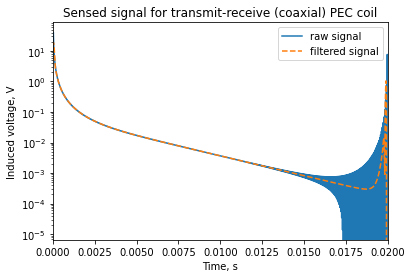

In [9]:
plt.plot(t, deltaV_intime)
plt.plot(t, deltaV_intime1, '--')
plt.yscale('log')
plt.xlim([0, 0.02])
plt.xlabel('Time, s')
plt.ylabel('Induced voltage, V')
plt.legend(['raw signal', 'filtered signal'])
plt.title('Sensed signal for transmit-receive (coaxial) PEC coil')